# DS 3000 - Assignment 10

**Student Name**: Ryan Tietjen

**Date**: 03/23/24


### Submission Instructions
Submit this `ipynb` file to canvas.

The `ipynb` format stores outputs from the last time you ran the notebook.  (When you open a notebook it has the figures and outputs of the last time you ran it too).  To ensure that your submitted `ipynb` file represents your latest code, make sure to give a fresh run `Kernel > Restart & Run All` just before uploading the `ipynb` file to Canvas.

### Academic Integrity

**Writing your homework is an individual effort.**  You may discuss general python problems with other students but under no circumstances should you observe another student's code which was written for this assignment, from this year or past years.  Pop into office hours or DM us in MS Teams if you have a specific question about your work or if you would like another pair of eyes or talk through your code.

Don't forget to cite websites which helped you solve a problem in a unique way.  You can do this in markdown near the code or with a simple one-line comment. You do not need to cite the official python documentation.

**Documentation / style counts for credit**  Please refer to the Pep-8 style, to improve the readability and consistency of your Python code. For more information, read the following article [How to Write Beautiful Python Code With PEP 8](https://realpython.com/python-pep8/) or ask your TA's for tips.

**NOTE:<span style='color:red'> Write python expressions to answer ALL questions below and ensure that you use the `print()` function to display the output.</span>** Each question should be answered in a new code cell. For example, your solution for question 1.1 should be in a different code cell from your solution for question 1.2.

## Question 1: 

Load the data directly from the URL into a DataFrame.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

tripdata_df = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet")

print(tripdata_df.head())
print(tripdata_df.dtypes)

   VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         1  2023-02-01 00:46:22   2023-02-01 01:05:57                  N   
1         2  2023-02-01 00:05:09   2023-02-01 00:22:42                  N   
2         2  2023-02-01 00:03:47   2023-02-01 00:27:30                  N   
3         2  2023-01-31 23:30:56   2023-01-31 23:51:40                  N   
4         2  2023-02-01 00:15:05   2023-02-01 00:26:02                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0         1.0            74           265              1.0          10.80   
1         1.0           216           196              1.0           4.76   
2         1.0             7           114              1.0           6.32   
3         1.0            74           239              1.0           3.50   
4         1.0            82           223              1.0           3.14   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  ehail_fee  \
0  

## Question 2: 
(10 pts) Data Prep & EDA
Prepare the data for analysis. You can reuse code snippets from assignment 4. However, update the logic based on the feedback you received. Ensure that you address the following:
Delete any widespread missing data and handle negative dollar amounts. Justify your approach to handling negative amounts.
Plot a histogram of the trip distance and explain the overall distribution.
Note: The findings from your previous analysis, in assignment 4, would have indicated that most customers use green taxis to travel short distances. Therefore, ensure that you use an appropriate method to handle any outlier trips.


In [2]:
tripdata_df['VendorID'] = tripdata_df['VendorID'].astype('category')
tripdata_df['store_and_fwd_flag'] = tripdata_df['store_and_fwd_flag'].astype('category')
tripdata_df['trip_type'] = tripdata_df['trip_type'].astype('category')
tripdata_df['RatecodeID'] = tripdata_df['RatecodeID'].astype('category')
tripdata_df['payment_type'] = tripdata_df['payment_type'].astype('category')

print("Checking initital null data occurances:")
print(tripdata_df.isnull().sum())

# It appears that every value of ehail_fee is empty, so it should be removed
tripdata_df.drop('ehail_fee', axis=1, inplace=True)


# In addition, it appears that the last 4821 rows are missing values for the columns: store_and_fwd_flag, 
# RatecodeID, passenger_count, payment_type, trip_type, congestion_surcharge, 
print("Checking the last 4281 rows to see that they contain several null values")
print(tripdata_df.tail(4824))

#Since many consecutive rows are impacted by this, we will remove the last 4824 rows
tripdata_df = tripdata_df[:-4821]

print("Checking null data after removing last 4821 rows")
print(tripdata_df.isnull().sum())

#There seems to be 5 more missing values in trip_type. Since they seem to be abritrary and infrequent, we will ignore them.
# Noteably, whenever trip_type is null, RatecodeID == 99. We will remove these invalid rows in the next section.
print("Checking that the remaining 5 null values appear to be random:")
print(tripdata_df[tripdata_df.isnull().any(axis=1)])

# There is an outlier case where the trip distance is really long. this will handle it 
tripdata_df = tripdata_df[tripdata_df['trip_distance'] <= 1000]

Checking initital null data occurances:
VendorID                     0
lpep_pickup_datetime         0
lpep_dropoff_datetime        0
store_and_fwd_flag        4821
RatecodeID                4821
PULocationID                 0
DOLocationID                 0
passenger_count           4821
trip_distance                0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
ehail_fee                64809
improvement_surcharge        0
total_amount                 0
payment_type              4821
trip_type                 4826
congestion_surcharge      4821
dtype: int64
Checking the last 4281 rows to see that they contain several null values
      VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
59985        2  2023-02-28 23:33:40   2023-02-28 23:42:16                  N   
59986        2  2023-02-28 23:21:27   2023-02-28 23:36:36                  N   
59987        2

In [3]:
# There are 370 instances where there are 0 passengers. This should not be possible, so we will remove these rows.
print("Initial number of instances where passenger_count == 0")
print(tripdata_df[tripdata_df['passenger_count'] == 0].shape[0])
tripdata_df = tripdata_df[tripdata_df['passenger_count'] != 0]

#Verify success
print("Final number of instances where passenger_count == 0")
print(tripdata_df[tripdata_df['passenger_count'] == 0].shape[0])

# There are 5 instances where RatecodeID is not 1-6. We will remove these rows
print("Initial number of instances where RatecodeID == 99")
print(tripdata_df[tripdata_df['RatecodeID'] == 99].shape[0])
tripdata_df = tripdata_df[tripdata_df['RatecodeID'] != 99]

#Verify success
print("Final number of instances where RatecodeID == 99")
print(tripdata_df[tripdata_df['RatecodeID'] == 0].shape[0])

# There are 2677 instances where trip_distance is 0. We will remove these rows because trip_distance cannot be zero.
print("Initial number of instances where trip_distance == 0")
print(tripdata_df[tripdata_df['trip_distance'] == 0].shape[0])
tripdata_df = tripdata_df[tripdata_df['trip_distance'] != 0]

#Verify success
print("Final number of instances where trip_distance == 0")
print(tripdata_df[tripdata_df['trip_distance'] == 0].shape[0])

# There are 154 instances where total_amount is <= 0. We will remove these rows because there cannot be a free taxi ride
# So, these values must be incorrect.
print("Initial number of instances where total_amount <= 0")
print(tripdata_df[tripdata_df['total_amount'] <= 0].shape[0])
tripdata_df = tripdata_df[tripdata_df['total_amount'] > 0]

#Verify success
print("Final number of instances where total_amount <= 0")
print(tripdata_df[tripdata_df['total_amount'] <= 0].shape[0])

Initial number of instances where passenger_count == 0
370
Final number of instances where passenger_count == 0
0
Initial number of instances where RatecodeID == 99
5
Final number of instances where RatecodeID == 99
0
Initial number of instances where trip_distance == 0
2677
Final number of instances where trip_distance == 0
0
Initial number of instances where total_amount <= 0
154
Final number of instances where total_amount <= 0
0


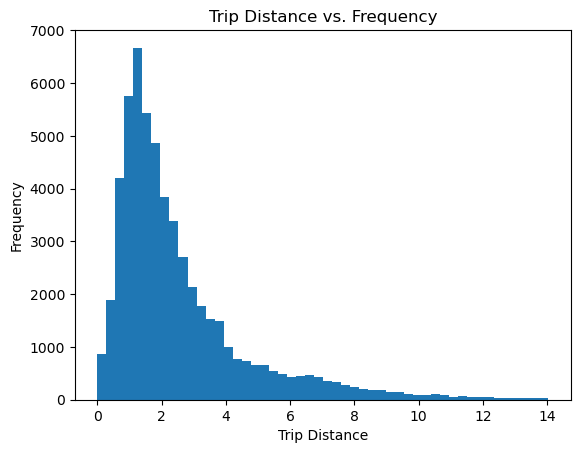

In [4]:
# quantile = .99 to exclude outliers (necessary)
plt.hist(tripdata_df['trip_distance'], bins=50, range=(0,tripdata_df['trip_distance'].quantile(.99))) 
plt.title('Trip Distance vs. Frequency')
plt.xlabel('Trip Distance')
plt.ylabel('Frequency')
plt.show()

The histogram of trip distances displays a strong right skew. This means that most trips tended to be of a shorter distance. 

## Question 3:

(10 pts) Feature Selection
Demonstrate which features are useful to build the model. Briefly explain the reason for the features that you selected.
Note: You can explore correlations, test hypothesis and/or other techniques. Remember that Data Science relies heavily on experimentation. Therefore, you are encouraged to experiment with your data.
Tip #1: ensure that you carefully consider each feature. For example, the total_amount is a variable in your dataframe; however the total amount for each trip can also be obtained if you add all the charges for each passenger (e.g. fare_amount + extra + mta_tax + tip_amount + tolls_amount + improvement_surcharge + congestion_surcharge). Therefore, is it best to include the total_amount in your model or the breakdown that shows each individual charge? Think about the pros and cons of your decisions.
Tip #2: you are predicting the tip amount, therefore it should not be one of your explanatory variables.

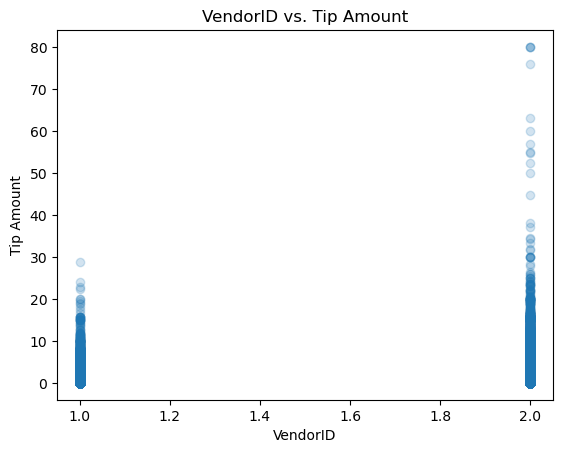

Correlation between VendorID and Tip Amount: 0.02


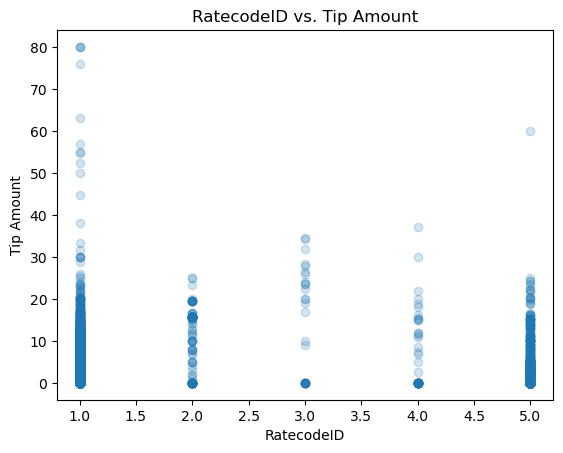

Correlation between RatecodeID and Tip Amount: 0.03


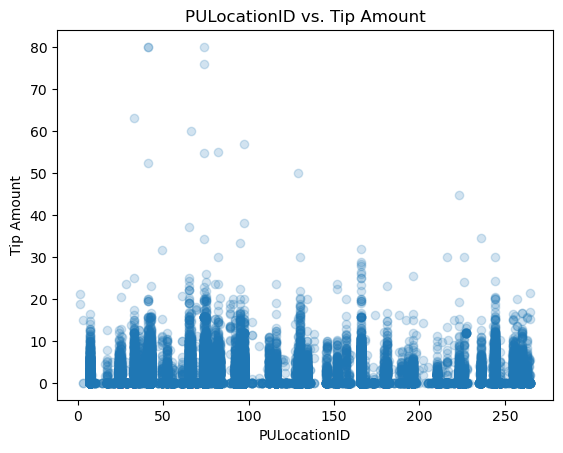

Correlation between PULocationID and Tip Amount: 0.03


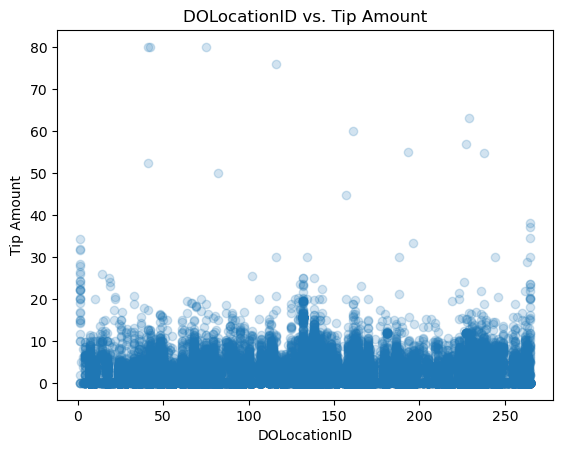

Correlation between DOLocationID and Tip Amount: 0.13


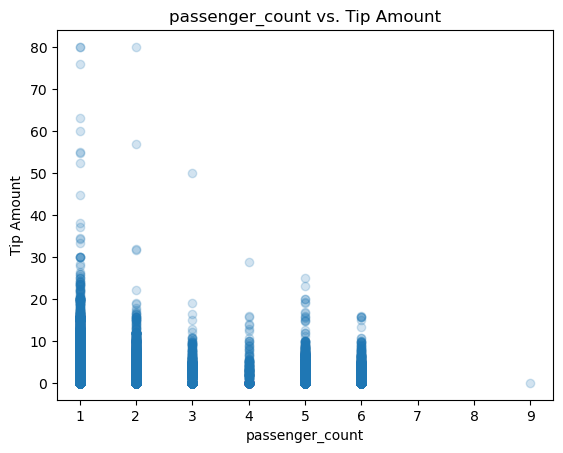

Correlation between passenger_count and Tip Amount: 0.02


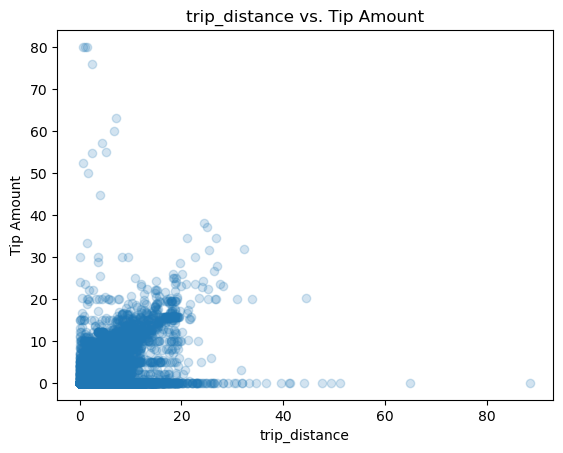

Correlation between trip_distance and Tip Amount: 0.37


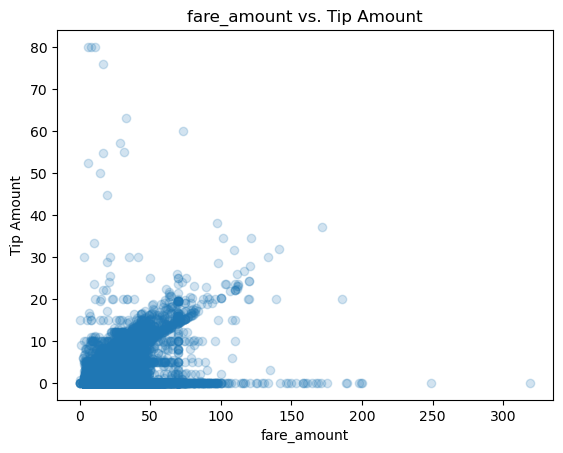

Correlation between fare_amount and Tip Amount: 0.38


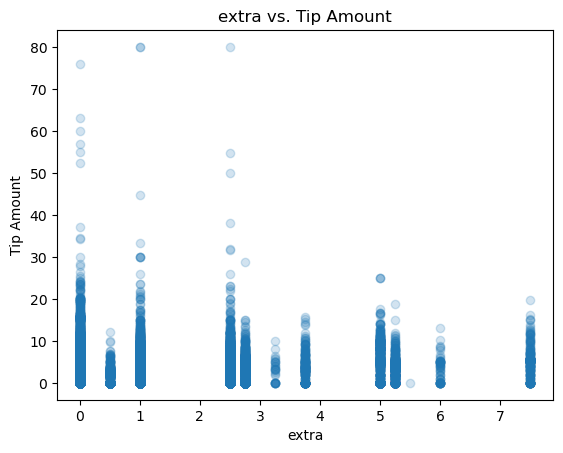

Correlation between extra and Tip Amount: 0.13


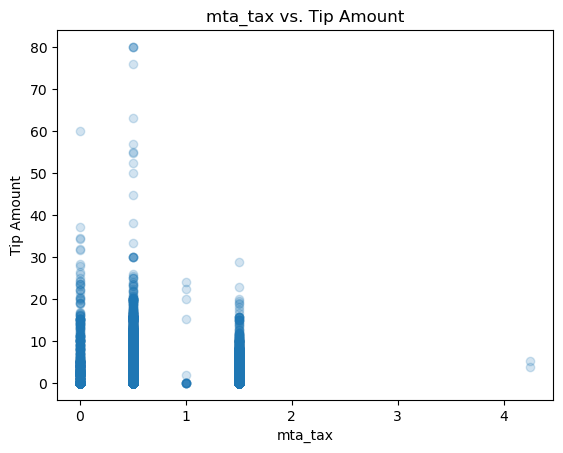

Correlation between mta_tax and Tip Amount: -0.02


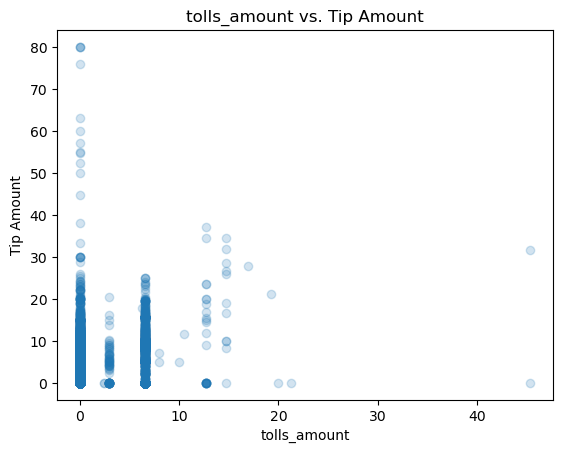

Correlation between tolls_amount and Tip Amount: 0.24


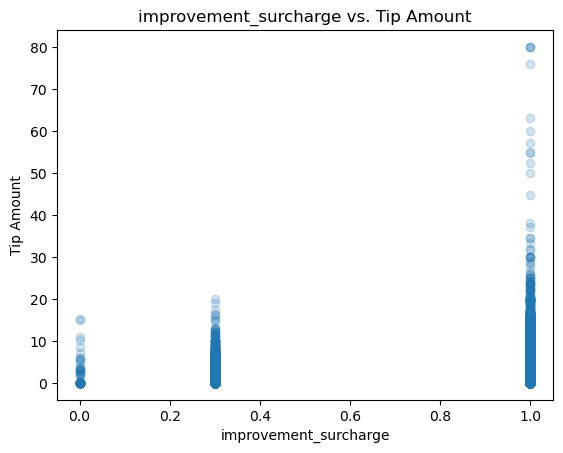

Correlation between improvement_surcharge and Tip Amount: 0.01


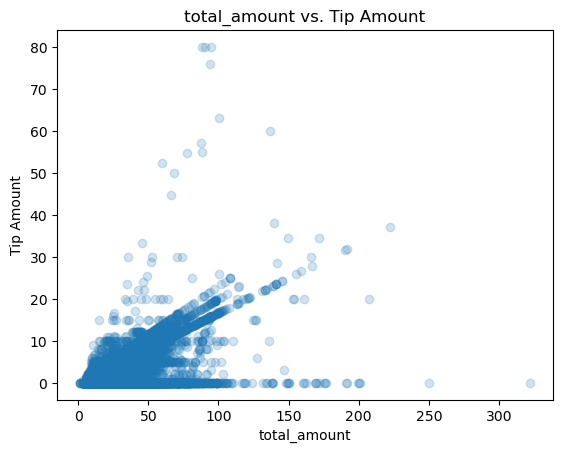

Correlation between total_amount and Tip Amount: 0.57


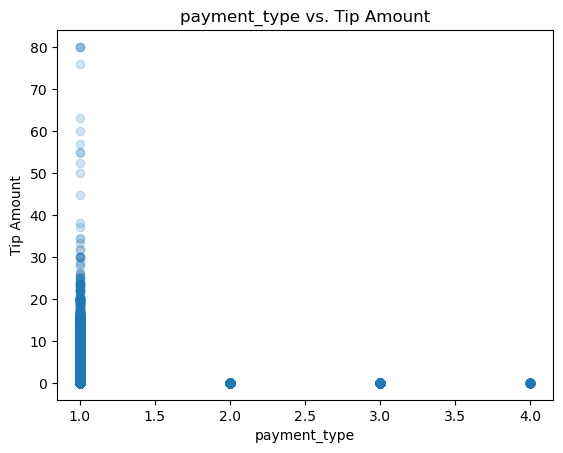

Correlation between payment_type and Tip Amount: -0.56


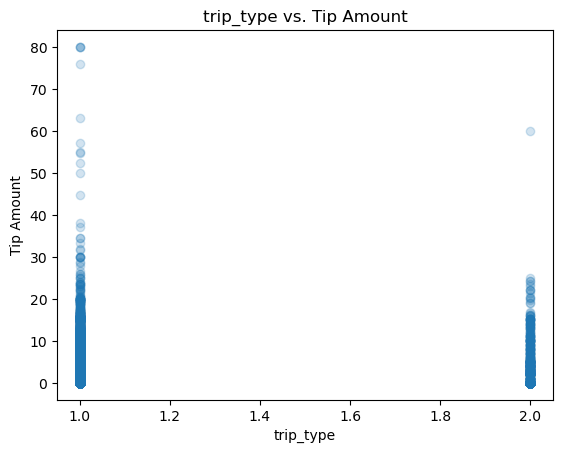

Correlation between trip_type and Tip Amount: 0.01


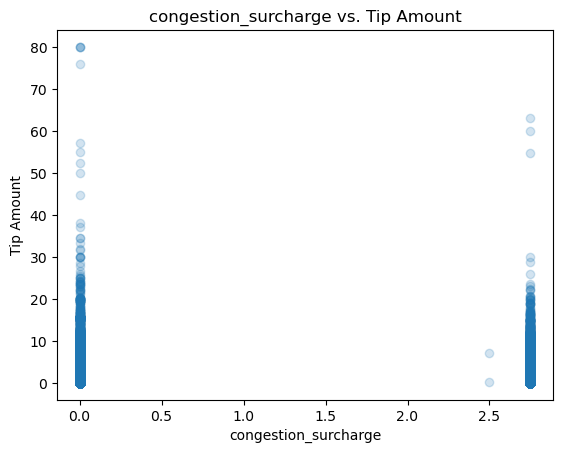

Correlation between congestion_surcharge and Tip Amount: 0.29


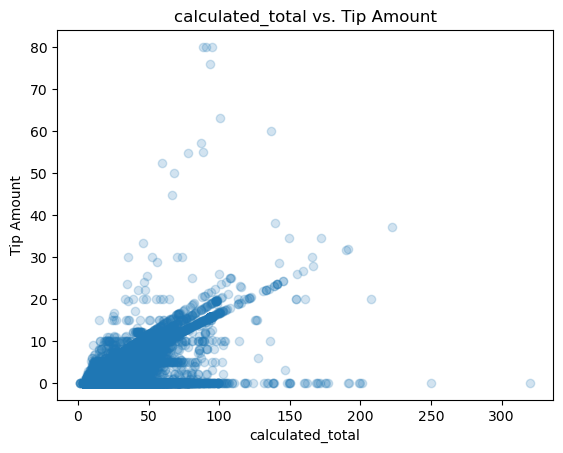

Correlation between calculated_total and Tip Amount: 0.57


In [5]:
tripdata_df['calculated_total'] = (tripdata_df['fare_amount'] +
                                   tripdata_df['extra'] +
                                   tripdata_df['mta_tax'] +
                                   tripdata_df['tip_amount'] +
                                   tripdata_df['tolls_amount'] +
                                   tripdata_df['improvement_surcharge'] +
                                   tripdata_df['congestion_surcharge'])

cols = ['VendorID', 'RatecodeID', 'PULocationID', 'DOLocationID',
        'passenger_count', 'trip_distance', 'fare_amount', 'extra',
        'mta_tax', 'tolls_amount', 'improvement_surcharge', 'total_amount',
        'payment_type', 'trip_type', 'congestion_surcharge', 'calculated_total']

for col in cols:
    plt.scatter(tripdata_df[col], tripdata_df['tip_amount'], alpha=0.2)
    plt.title(f'{col} vs. Tip Amount')
    plt.xlabel(col)
    plt.ylabel('Tip Amount')
    plt.show()
    
    print(f"Correlation between {col} and Tip Amount: {tripdata_df[col].corr(tripdata_df['tip_amount']):.2f}")

Chosen features: trip_distance, fare_amount, total_amount, payment_type

note: total_amount was chosen over calculated_total because calculated_total includes the tip amount (We would not want to compare tip amount against itself).

The reason I chose these features is because they all had the strongest correlations with tip amount. Also, these values align with the following hypotheses:

-People are likely to tip more for longer trips

-People are likely to tip more for more expensive trips (following the idea of a ~20% tip). This extends to both fare_amount and calculated_total.

-People may be more likely to tip if they are paying with cash over card.

## Question 4:

Data Partitioning
(5 pts) Partition the prepared data into train/test sets, ensure that your partitions are reproducible. Encode any categorical variables in your training set. Then, use the appropriate approach to encode your test set.

In [6]:
X = tripdata_df[['trip_distance', 'fare_amount', 'total_amount', 'payment_type']]
y = tripdata_df['tip_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31)

print('X_train data: {}'.format(X_train[0:5]))
print('-------------------------------------')
print('X_test data: {}'.format(X_test[0:5]))
print('-------------------------------------')
print('y_train data: {}'.format(y_train[0:5]))
print('-------------------------------------')
print('y_test data: {}'.format(y_test[0:5]))

X_train data:        trip_distance  fare_amount  total_amount payment_type
3919            1.21         10.0         14.00          1.0
43445           1.28          8.6         12.12          1.0
23836           1.59         12.1         16.32          1.0
6187            1.69         13.5         17.50          2.0
47041           4.29         21.9         25.90          2.0
-------------------------------------
X_test data:        trip_distance  fare_amount  total_amount payment_type
16052           3.20         20.5         27.50          1.0
17573           5.01         27.5         31.05          1.0
48715           1.62         10.7         19.11          1.0
22240          18.73        106.6        130.92          1.0
46403           4.54         24.7         26.20          2.0
-------------------------------------
y_train data: 3919     0.00
43445    2.02
23836    2.72
6187     0.00
47041    0.00
Name: tip_amount, dtype: float64
-------------------------------------
y_test dat

## Question 5:

Model Development
(5 pts) Using the Random Forest algorithm, build a machine learning model that predicts the tip amount.
Think about the following: Are you performing classification or regression? Ensure that you choose the appropriate Random Forest Classifier/Regressor from scikit-learn.

In [7]:
rf = RandomForestRegressor(random_state=31)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

## Question 6:

Model Evaluation
(5 pts) Evaluate the predictions from your model and comment on the results. Ensure that you choose the appropriate metric to evaluate the model and round your calculations to two decimal places. Remember that we evaluate models differently depending on the task, i.e. classification or regression.


In [8]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {np.sqrt(mse):.2f}")
print(f"R^2: {r2:.2f}")

print(tripdata_df['tip_amount'].describe().round(2))

MSE: 0.67
RMSE: 0.82
R^2: 0.92
count    56781.00
mean         2.14
std          2.81
min          0.00
25%          0.00
50%          1.74
75%          3.35
max         80.00
Name: tip_amount, dtype: float64


A MSE of .67 indicates that the model, on average, has a squared error of .67.

A RMSE of .82 indicates that the model's predictions deviate from the mean by an average of .82 (82 cents). Given that the mean tip is 2.14, an RMSE of 0.82 represents a moderate error.

An r^2 value of .92 indicates that 92% of the variance in the tip amount can be explained by the model.

## Question 7:

Model Tuning
(15 pts) What are your thoughts on the model's prediction capability? Did it do a good job of predicting the tip_amount?
Note: it is okay if your first version of the model is not the best. However, there are strategies that we can use to improve it, such as tuning.
Tune the model: you can control the number of trees in your forest using the n_estimators parameter. Refer to the sample code from the lecture and also view the documentation**Links to an external site. to learn more about this algorithm and its parameters. Try at least five different values for the n_estimators parameter to determine if the model improved. Show all your steps to create, evaluate and tune each version of the model.
Indicate which model performed the best.

The r^2 value of .92 is fairly high, which means that the model is able to successfully capture most of the variability. However, the RMSE is still relatively high, which could definetly be improved upon

In [9]:
n_estimators = [10, 25, 50, 75, 100, 1000]

for n in n_estimators:
    rf = RandomForestRegressor(n_estimators=n, random_state=31)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_train)
    
    mse = round(mean_squared_error(y_train, y_pred),2)
    rmse = round(np.sqrt(mse), 2)
    r2 = round(r2_score(y_train, y_pred), 2)
    
    print(f'n_estimators: {n}, MSE: {mse}, RMSE: {rmse}, R^2: {r2}')

n_estimators: 10, MSE: 0.12, RMSE: 0.35, R^2: 0.98
n_estimators: 25, MSE: 0.1, RMSE: 0.32, R^2: 0.99
n_estimators: 50, MSE: 0.09, RMSE: 0.3, R^2: 0.99
n_estimators: 75, MSE: 0.09, RMSE: 0.3, R^2: 0.99
n_estimators: 100, MSE: 0.09, RMSE: 0.3, R^2: 0.99
n_estimators: 1000, MSE: 0.08, RMSE: 0.28, R^2: 0.99


After tuning the model, it appears that a n_estimator value of 1000 resulted in the best model.
n_estimators: 1000, MSE: 0.08, RMSE: 0.28, R^2: 0.99
A MSE of .08 indicates that the model, on average, has a squared error of .08.

A RMSE of .28 indicates that the model's predictions deviate from the mean by an average of .28 (28 cents). Given that the mean tip is 2.14, an RMSE of 0.28 represents a low error.

An r^2 value of 0.99 indicates that 99% of the variance in the tip amount can be explained by the model.

Hence, this version of the model is much better than the previous version.

That being said, n_estimator values of 10, 25, 50, 75, and 100 delivered models of very similar accuracy, but were able to run much quicker than an n_estimator value of 1000.

## Question 8:
    
(+5 bonus points) The Random forest has a method that returns the importance of each feature in your model. Review the documentation to learn about feature importance. After which, write the appropriate code that demonstrates which features were the most important when making the predictions. Visualize the feature importance using the best model and explain the results.

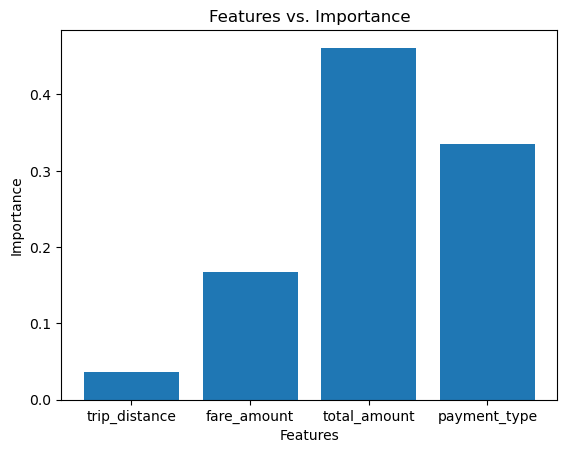

trip_distance: 0.04
fare_amount: 0.17
total_amount: 0.46
payment_type: 0.34


In [10]:
importances = rf.feature_importances_
features = ['trip_distance', 'fare_amount', 'total_amount', 'payment_type']

plt.bar(features, importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Features vs. Importance')
plt.show()

for i in range(len(features)):
    print(f"{features[i]}: {importances[i]:.2f}")

From these results, we can see that total_amount was the most important predictor for tip amount at a value of .46. Payment type was the next most important predictor at .33. The other two predictors were less important, with trip_distance only having an importance of .04.

## Helpful resources 
Don't forget to cite websites which helped you solve a problem in a unique way.  You can do this in markdown near the code or with a simple one-line comment inside the code cell, or you can list them below. 

You do not need to cite the official python documentation.
